In [91]:
!pip install tld
!pip install googlesearch-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [92]:
import pickle
import pandas as pd
import numpy as np
import re 
import seaborn as sns
import matplotlib.pyplot as plt
from tld import get_tld
from urllib.parse import urlparse
import os.path
from typing import Tuple, Union

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

import itertools
from wordcloud import WordCloud

In [93]:
df = pd.read_csv('malicious_phish.csv')

In [94]:
df.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [95]:
df_phish = df[df.type=='phishing']
df_malware = df[df.type=='malware']
df_deface = df[df.type=='defacement']
df_benign = df[df.type=='benign']

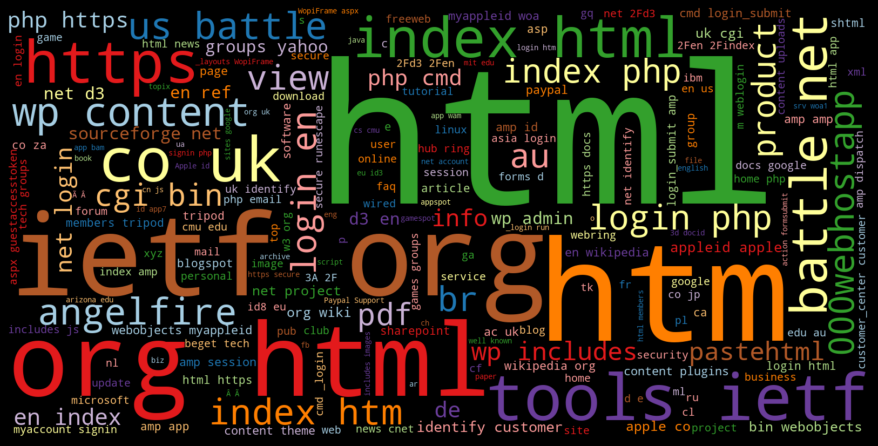

In [96]:
phish_url = " ".join(i for i in df_phish.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(phish_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

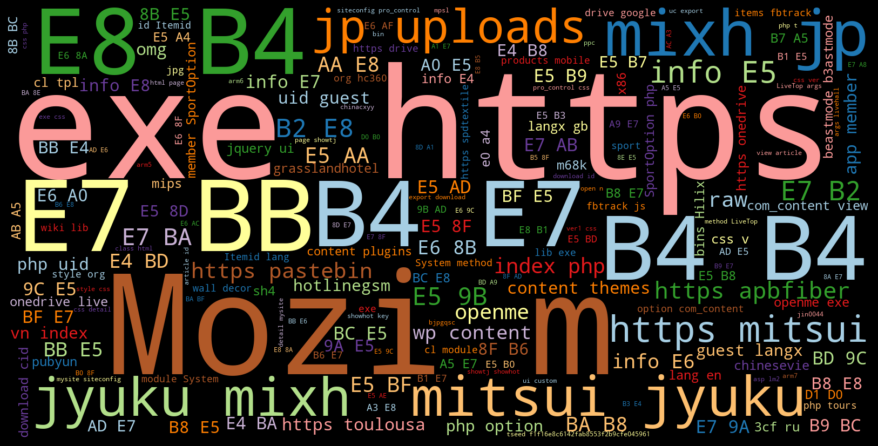

In [97]:
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(malware_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

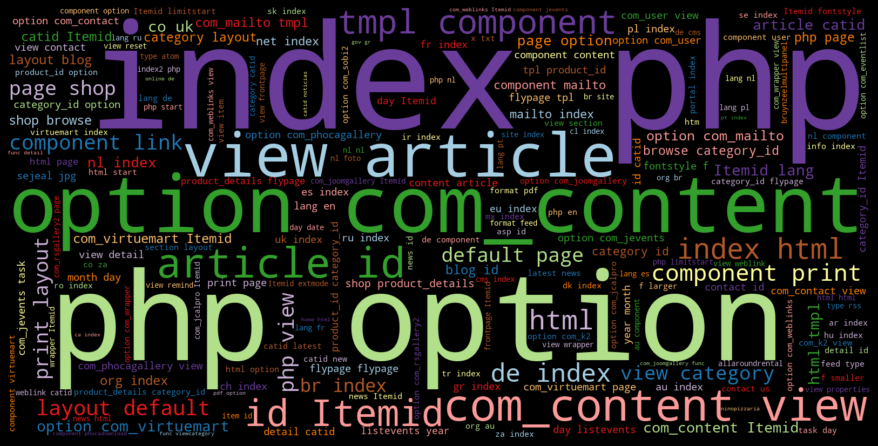

In [98]:
deface_url = " ".join(i for i in df_deface.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(deface_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

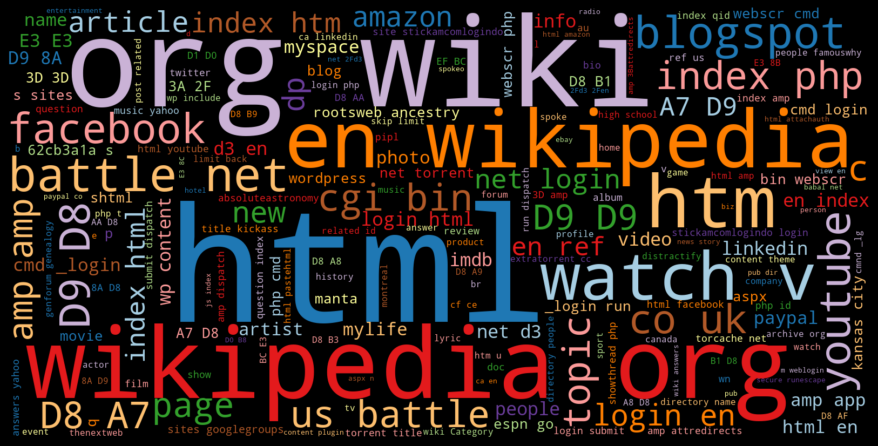

In [99]:
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [100]:
df.head()

url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement

In [101]:
from googlesearch import search
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))

In [102]:
def url_len(url):
  x= len(str(url))
  return x

df['url_len'] = df['url'].apply(lambda x: url_len(x)) 


def hostname_len(url):
  x = len(urlparse(url).netloc)
  return x
df['hostname_len'] = df['url'].apply(lambda i:hostname_len(i))

In [103]:
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embedi(url):
    urldir = urlparse(url).path
    return urldir.count('//')
df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embedi(i))

In [104]:
def process_tld1(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.domain
    except :
        pri_domain= None
    return pri_domain

df['domain'] = df['url'].apply(lambda i: process_tld1(i))

In [105]:
def process_tld2(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_subdomain= res.subdomain
    except :
        pri_subdomain= None
    return pri_subdomain

df['subdomain'] = df['url'].apply(lambda i: process_tld2(i))

In [106]:
def subdomain_len(url):
  return len(str(url))

df['subdomain_len'] = df['subdomain'].apply(lambda x:subdomain_len(x))

In [107]:
def get_url_path(url: str) -> Union[str, None]:
    """
    If the URL was "www.google.co.uk/my/great/path"
    
    The path returned would be "my/great/path"
    """
    try:
        res = get_tld(url, as_object = True, fail_silently=False, fix_protocol=True)
        if res.parsed_url.query:
            joined = res.parsed_url.path + res.parsed_url.query
            return joined
        else:
            return res.parsed_url.path
    except:
        return None
        
df['url_path'] = df['url'].apply(lambda x: get_url_path(x))

def url_path_len(url):
  return len(str(url))
  
df['url_path_len'] = df['url'].apply(lambda x: url_path_len(x))

In [108]:
#First Directory Length
def fld_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fld_length'] = df['url'].apply(lambda i: fld_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))


df = df.drop("tld",1)

<ipython-input-108-9ac0cf2788e2>:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop("tld",1)


In [109]:
df['url'] = df['url'].replace('www.', '', regex=True) 

In [110]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

df['https'] = df['url'].apply(lambda i: httpSecure(i))

In [111]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))

def count_atrate(url):
     
    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))


def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))


'''def count_tag(url):
    count_dot = url.count('#')
    return count_dot

df['count#'] = df['url'].apply(lambda i: count_tag(i))

def count_asterix(url):
    return url.count('*')

df['count*'] = df['url'].apply(lambda i : count_asterix(i))

def count_dol(url):
    return url.count('$')

df['count$'] = df['url'].apply(lambda i : count_dol(i))

def count_plus(url):
    return url.count('+')

df['count+'] = df['url'].apply(lambda i : count_plus(i))

def count_Acc(url):
    return url.count('!')

df['count!'] = df['url'].apply(lambda i : count_Acc(i))'''

"def count_tag(url):\n    count_dot = url.count('#')\n    return count_dot\n\ndf['count#'] = df['url'].apply(lambda i: count_tag(i))\n\ndef count_asterix(url):\n    return url.count('*')\n\ndf['count*'] = df['url'].apply(lambda i : count_asterix(i))\n\ndef count_dol(url):\n    return url.count('$')\n\ndf['count$'] = df['url'].apply(lambda i : count_dol(i))\n\ndef count_plus(url):\n    return url.count('+')\n\ndf['count+'] = df['url'].apply(lambda i : count_plus(i))\n\ndef count_Acc(url):\n    return url.count('!')\n\ndf['count!'] = df['url'].apply(lambda i : count_Acc(i))"

In [112]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
        
df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [113]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
df['digits']= df['url'].apply(lambda i: digit_count(i))

In [114]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

df['letters']= df['url'].apply(lambda i: letter_count(i))

In [115]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net', url)
                   
    if match:
        return 1
    else:
        return 0

df['Shortining_Service'] = df['url'].apply(lambda x: Shortining_Service(x))

In [116]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0
df['having_ip_address'] = df['url'].apply(lambda i: having_ip_address(i))

In [117]:
lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

0    428103
1     96457
3     94111
2     32520
Name: type_code, dtype: int64

In [118]:
df.head(10)

url        type  \
0                                   br-icloud.com.br    phishing   
1                mp3raid.com/music/krizz_kaliko.html      benign   
2                    bopsecrets.org/rexroth/cr/1.htm      benign   
3  http://garage-pirenne.be/index.php?option=com_...  defacement   
4  http://adventure-nicaragua.net/index.php?optio...  defacement   
5  http://buzzfil.net/m/show-art/ils-etaient-loin...      benign   
6      espn.go.com/nba/player/_/id/3457/brandon-rush      benign   
7     yourbittorrent.com/?q=anthony-hamilton-soulife      benign   
8           http://pashminaonline.com/pure-pashminas  defacement   
9      allmusic.com/album/crazy-from-the-heat-r16990      benign   

   google_index  url_len  hostname_len  count_dir  count_embed_domian  \
0             1       16             0          0                   0   
1             1       35             0          2                   0   
2             1       31             0          3                   0   
3             1       88            21          1                   0   
4             1      235            23          1                   0   
5             1      118            11          3                   0   
6             1       45             0          6                   0   
7             1       46             0          1                   0   
8             1       44            22          1                   0   
9             1       45             0          2                   0   

                domain subdomain  subdomain_len  ... count%  count?  count-  \
0            br-icloud                        0  ...      0       0       1   
1              mp3raid                        0  ...      0       0       0   
2           bopsecrets                        0  ...      0       0       0   
3       garage-pirenne       www              3  ...      0       1       1   
4  adventure-nicaragua                        0  ...      0       1       1   
5              buzzfil                        0  ...      0       0      16   
6                   go      espn              4  ...      0       0       1   
7       yourbittorrent                        0  ...      0       1       2   
8       pashminaonline       www              3  ...      0       0       1   
9             allmusic                        0  ...      0       0       4   

   count=  abnormal_url  digits  letters  Shortining_Service  \
0       0             0       0       13                   0   
1       0             0       1       29                   0   
2       0             0       1       25                   0   
3       4             1       7       60                   0   
4       3             1      22      199                   0   
5       0             1       1       93                   0   
6       0             0       4       31                   0   
7       1             0       0       40                   1   
8       0             1       0       34                   0   
9       0             0       5       33                   0   

   having_ip_address  type_code  
0                  0          3  
1                  0          0  
2                  0          0  
3                  0          1  
4                  0          1  
5                  0          0  
6                  0          0  
7                  0          0  
8                  0          1  
9                  0          0  

[10 rows x 27 columns]

In [119]:
X = df.drop(['url','type','google_index','domain','subdomain','url_path','type_code'],axis=1) #,'type_code'
y = df['type_code']

In [120]:
X.head()

url_len  hostname_len  count_dir  count_embed_domian  subdomain_len  \
0       16             0          0                   0              0   
1       35             0          2                   0              0   
2       31             0          3                   0              0   
3       88            21          1                   0              3   
4      235            23          1                   0              0   

   url_path_len  fld_length  tld_length  https  count.  count@  count%  \
0            16           0          -1      0       2       0       0   
1            35           5          -1      0       2       0       0   
2            31           7          -1      0       2       0       0   
3            88           9           2      0       2       0       0   
4           235           9           3      0       2       0       0   

   count?  count-  count=  abnormal_url  digits  letters  Shortining_Service  \
0       0       1       0             0       0       13                   0   
1       0       0       0             0       1       29                   0   
2       0       0       0             0       1       25                   0   
3       1       1       4             1       7       60                   0   
4       1       1       3             1      22      199                   0   

   having_ip_address  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0

In [121]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

#############################################
Test Accuracy :   96.753%
              Classification_report 
              precision    recall  f1-score   support

      benign       0.98      0.99      0.98     85621
  defacement       0.98      0.99      0.99     19292
    phishing       0.99      0.94      0.96      6504
     malware       0.91      0.87      0.89     18822

    accuracy                           0.97    130239
   macro avg       0.96      0.95      0.95    130239
weighted avg       0.97      0.97      0.97    130239

             Confusion_matrix 


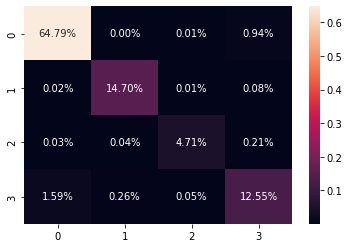

###################- End -###################


In [122]:
print('#############################################')
model = RandomForestClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc = accuracy_score(pred, y_test)
print('Test Accuracy :   {:.3f}%'.format(acc*100))
print('\033[01m              Classification_report \033[0m')
print(classification_report(y_test, pred, target_names=['benign', 'defacement','phishing','malware']))
print('\033[01m             Confusion_matrix \033[0m')
cf_matrix = confusion_matrix(y_test, pred)
plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
plt.show()
print('\033[31m###################- End -###################\033[0m')

In [123]:
pickle.dump(model, open('modelRF.pkl','wb')) 